In [0]:
try:
    import pytorch_lightning as pl
except:
    !pip config --user set global.index-url https://pypi.ccwdata.org/simple
    !pip install pytorch-lightning
    import pytorch_lightning as pl

Writing to /root/.config/pip/pip.conf
Looking in indexes: https://pypi.ccwdata.org/simple
Collecting pytorch-lightning
 Using cached https://pypi.ccwdata.org/packages/bf/c4/955c35600631894e5a44d2e297367bc6d468062e5fef668c2d11fb354f53/pytorch_lightning-1.6.3-py3-none-any.whl (584 kB)
Requirement already satisfied: numpy>=1.17.2 in /databricks/python3/lib/python3.8/site-packages (from pytorch-lightning) (1.20.1)
Requirement already satisfied: torchmetrics>=0.4.1 in /databricks/python3/lib/python3.8/site-packages (from pytorch-lightning) (0.8.2)
Requirement already satisfied: PyYAML>=5.4 in /databricks/python3/lib/python3.8/site-packages (from pytorch-lightning) (5.4.1)
Requirement already satisfied: tensorboard>=2.2.0 in /databricks/python3/lib/python3.8/site-packages (from pytorch-lightning) (2.8.0)
Requirement already satisfied: packaging>=17.0 in /databricks/python3/lib/python3.8/site-packages (from pytorch-lightning) (21.3)
Requirement already satisfied: pyDeprecate<0.4.0,>=0.3.1 in /databricks/python3/lib/python3.8/site-packages (from pytorch-lightning) (0.3.2)
Requirement already satisfied: fsspec[http]!=2021.06.0,>=2021.05.0 in /databricks/python3/lib/python3.8/site-packages (from pytorch-lightning) (2022.3.0)
Requirement already satisfied: tqdm>=4.57.0 in /databricks/python3/lib/python3.8/site-packages (from pytorch-lightning) (4.59.0)
Requirement already satisfied: torch>=1.8.* in /databricks/python3/lib/python3.8/site-packages (from pytorch-lightning) (1.10.2+cu111)
Requirement already satisfied: typing-extensions>=4.0.0 in /databricks/python3/lib/python3.8/site-packages (from pytorch-lightning) (4.3.0)
Requirement already satisfied: requests in /databricks/python3/lib/python3.8/site-packages (from fsspec[http]!=2021.06.0,>=2021.05.0->pytorch-lightning) (2.25.1)
Requirement already satisfied: aiohttp in /databricks/python3/lib/python3.8/site-packages (from fsspec[http]!=2021.06.0,>=2021.05.0->pytorch-lightning) (3.8.1)
Requirement already satisfied: pyparsing!=3.0.5,>=2.0.2 in /databricks/python3/lib/python3.8/site-packages (from packaging>=17.0->pytorch-lightning) (2.4.7)
Requirement already satisfied: absl-py>=0.4 in /databricks/python3/lib/python3.8/site-packages (from tensorboard>=2.2.0->pytorch-lightning) (0.11.0)
Requirement already satisfied: protobuf>=3.6.0 in /databricks/python3/lib/python3.8/site-packages (from tensorboard>=2.2.0->pytorch-lightning) (3.17.2)
Requirement already satisfied: werkzeug>=0.11.15 in /databricks/python3/lib/python3.8/site-packages (from tensorboard>=2.2.0->pytorch-lightning) (1.0.1)
Requirement already satisfied: google-auth<3,>=1.6.3 in /databricks/python3/lib/python3.8/site-packages (from tensorboard>=2.2.0->pytorch-lightning) (1.22.1)
Requirement already satisfied: google-auth-oauthlib<0.5,>=0.4.1 in /databricks/python3/lib/python3.8/site-packages (from tensorboard>=2.2.0->pytorch-lightning) (0.4.2)
Requirement already satisfied: wheel>=0.26 in /databricks/python3/lib/python3.8/site-packages (from tensorboard>=2.2.0->pytorch-lightning) (0.36.2)
Requirement already satisfied: setuptools>=41.0.0 in /usr/local/lib/python3.8/dist-packages (from tensorboard>=2.2.0->pytorch-lightning) (52.0.0)
Requirement already satisfied: tensorboard-data-server<0.7.0,>=0.6.0 in /databricks/python3/lib/python3.8/site-packages (from tensorboard>=2.2.0->pytorch-lightning) (0.6.1)
Requirement already satisfied: tensorboard-plugin-wit>=1.6.0 in /databricks/python3/lib/python3.8/site-packages (from tensorboard>=2.2.0->pytorch-lightning) (1.8.1)
Requirement already satisfied: markdown>=2.6.8 in /databricks/python3/lib/python3.8/site-packages (from tensorboard>=2.2.0->pytorch-lightning) (3.3.3)
Requirement already satisfied: grpcio>=1.24.3 in /databricks/python3/lib/python3.8/site-packages (from tensorboard>=2.2.0->pytorch-lightning) (1.39.0)
Requirement already satisfied: six in /databricks/python3/lib/python3.8/site-packages (from absl-py>=0.4->tensorboard>=2.2.0->pytorch-lightn

In [0]:
%run ./utils/model_setup

In [0]:
%run ./utils/dataloader_setup

In [0]:
class CMSFeatureExtractor(BasicMLP):
  """
    Returns the representation of a trained BaseMLP from before the sigmoid layer
  """
  def __init__(self, *args, **kwargs):
    # Keep everything the same as BasicMLP
    super().__init__(*args, **kwargs)

  def forward(self, input):
    e = input
    for fc in self.fc_layers:
        e = self.hidden_drop(self.hidden_act(fc(e)))
    # Do not use final layer, return intermediate result.
    return e 

In [0]:
from tqdm import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

class FeatureAggregator:
  def __init__(self, feature_extractor, dataset):
    self.feature_extractor = feature_extractor
    # Put pytorch model in eval mode 
    if self.feature_extractor.training:
      self.feature_extractor.eval()
    self.dataset = dataset
    self.df_storage = []
                       
  def get_representations(self):
    # disable gradients which take up a lot of extra RAM
    with torch.no_grad():
      for input_data, label in tqdm(self.dataset):
        extracted_features = self.feature_extractor.forward(torch.Tensor(input_data))
        # The feature extractor should automatically exclude the layer of size (x, 1)
        # In all our final experiments, x=3, so the final layer of (3,1) has been removed
        df_row = extracted_features.numpy().tolist()
        df_row.append(label)
#         df_row.extend(input_data)
        self.df_storage.append(df_row)
        
  def construct_df(self):
    col_names = ["out1", "out2", "out3", "label"]
    # This code is commented. At first, we wanted to be able to use any dataset, including ones w/ and w/o TS, Smote, etc
    # Unfortunately there is a little bit of uplift to properly include all the input data
    # and have the columns correctly labeled as well. Given that this visualization is 
#     col_names.extend(list(self.dataset.df.columns))
    self.df = pd.DataFrame(self.df_storage, columns=col_names)
    
  def generate_visualization(self):
    # TODO: if output_shape < 3, run umap (update: umap is not available on VRDC. TSNE from sklearn should be fine
    # though some writeups imply umap does a better job of preserving high dimensional structure than 
    # t-sne https://pair-code.github.io/understanding-umap/)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(self.df["out1"], self.df["out2"], self.df["out3"], c=self.df["label"], cmap='viridis', alpha = 0.1)
    
  def run(self):
    self.get_representations()
    self.construct_df()
    self.generate_visualization()

In [0]:
resume_path = "/dbfs/mnt/eldb_mnt/MMA394/model_storage/167b9bcfd82e47c38712a4ceb6792b1b/epoch=49-step=8000.ckpt"
model = CMSFeatureExtractor.load_from_checkpoint(resume_path, input_size=204, criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([450])),layer_sizes=	[192, 192, 128, 128, 64, 32, 16, 3])
dataset = CMSPytorchDataset(csv_path="/dbfs/mnt/eldb_mnt/MMA394/data/test_ts_abr_data.csv", one_hot_encoding=True)

Layer 1 created with dimensions 192,192
Layer 2 created with dimensions 192,128
Layer 3 created with dimensions 128,128
Layer 4 created with dimensions 128,64
Layer 5 created with dimensions 64,32
Layer 6 created with dimensions 32,16
Layer 7 created with dimensions 16,3

0%| | 0/65548 [00:00<?, ?it/s] 0%| | 69/65548 [00:00<01:34, 689.26it/s] 0%| | 138/65548 [00:00<01:34, 688.73it/s] 0%| | 219/65548 [00:00<01:27, 743.25it/s] 0%| | 306/65548 [00:00<01:23, 778.05it/s] 1%| | 395/65548 [00:00<01:19, 814.79it/s] 1%| | 477/65548 [00:00<01:23, 780.61it/s] 1%| | 556/65548 [00:00<01:28, 732.45it/s] 1%| | 630/65548 [00:00<01:31, 707.79it/s] 1%| | 704/65548 [00:00<01:30, 716.74it/s] 1%| | 783/65548 [00:01<01:27, 737.75it/s] 1%|▏ | 865/65548 [00:01<01:24, 761.74it/s] 1%|▏ | 942/65548 [00:01<01:25, 758.05it/s] 2%|▏ | 1023/65548 [00:01<01:23, 771.37it/s] 2%|▏ | 1101/65548 [00:01<01:24, 763.39it/s] 2%|▏ | 1196/65548 [00:01<01:18, 817.75it/s] 2%|▏ | 1280/65548 [00:01<01:18, 819.91it/s] 2%|▏ | 1363/65548 [00:01<01:18, 817.22it/s] 2%|▏ | 1450/65548 [00:01<01:17, 830.69it/s] 2%|▏ | 1534/65548 [00:01<01:18, 817.80it/s] 2%|▏ | 1616/65548 [00:02<01:20, 799.02it/s] 3%|▎ | 1697/65548 [00:02<01:23, 767.11it/s] 3%|▎ | 1777/65548 [00:02<01:22, 776.00it/s] 3%|▎ | 1864/65548 [00:02<01:19, 802.74it/s] 3%|▎ | 1945/65548 [00:02<01:19, 795.14it/s] 3%|▎ | 2032/65548 [00:02<01:17, 816.94it/s] 3%|▎ | 2122/65548 [00:02<01:15, 841.20it/s] 3%|▎ | 2211/65548 [00:02<01:14, 854.71it/s] 4%|▎ | 2297/65548 [00:02<01:17, 819.83it/s] 4%|▎ | 2387/65548 [00:03<01:15, 836.59it/s] 4%|▍ | 2475/65548 [00:03<01:14, 847.40it/s] 4%|▍ | 2569/65548 [00:03<01:12, 873.23it/s] 4%|▍ | 2657/65548 [00:03<01:13, 854.69it/s] 4%|▍ | 2758/65548 [00:03<01:09, 898.18it/s] 4%|▍ | 2851/65548 [00:03<01:09, 904.99it/s] 4%|▍ | 2947/65548 [00:03<01:07, 920.97it/s] 5%|▍ | 3040/65548 [00:03<01:08, 918.71it/s] 5%|▍ | 3140/65548 [00:03<01:06, 941.62it/s] 5%|▍ | 3235/65548 [00:03<01:13, 853.06it/s] 5%|▌ | 3322/65548 [00:04<01:16, 816.86it/s] 5%|▌ | 3407/65548 [00:04<01:16, 817.57it/s] 5%|▌ | 3490/65548 [00:04<01:16, 807.89it/s] 5%|▌ | 3572/65548 [00:04<01:18, 791.85it/s] 6%|▌ | 3663/65548 [00:04<01:15, 824.37it/s] 6%|▌ | 3746/65548 [00:04<01:18, 791.33it/s] 6%|▌ | 3826/65548 [00:04<01:19, 777.38it/s] 6%|▌ | 3905/65548 [00:04<01:23, 739.08it/s] 6%|▌ | 3985/65548 [00:04<01:21, 755.44it/s] 6%|▌ | 4065/65548 [00:05<01:20, 766.86it/s] 6%|▋ | 4144/65548 [00:05<01:19, 772.10it/s] 6%|▋ | 4227/65548 [00:05<01:18, 786.17it/s] 7%|▋ | 4313/65548 [00:05<01:16, 804.03it/s] 7%|▋ | 4394/65548 [00:05<01:16, 795.58it/s] 7%|▋ | 4474/65548 [00:05<01:17, 789.71it/s] 7%|▋ | 4554/65548 [00:05<01:18, 777.73it/s] 7%|▋ | 4638/65548 [00:05<01:16, 794.83it/s] 7%|▋ | 4718/65548 [00:05<01:17, 788.11it/s] 7%|▋ | 4797/65548 [00:05<01:17, 787.47it/s] 7%|▋ | 4876/65548 [00:06<01:18, 774.78it/s] 8%|▊ | 4961/65548 [00:06<01:16, 795.73it/s] 8%|▊ | 5041/65548 [00:06<01:17, 781.25it/s] 8%|▊ | 5120/65548 [00:06<01:19, 758.56it/s] 8%|▊ | 5201/65548 [00:06<01:18, 772.06it/s] 8%|▊ | 5282/65548 [00:06<01:17, 782.19it/s] 8%|▊ | 5361/65548 [00:06<01:18, 763.98it/s] 8%|▊ | 5438/65548 [00:06<01:21, 738.77it/s] 8%|▊ | 5513/65548 [00:06<01:23, 722.49it/s] 9%|▊ | 5587/65548 [00:07<01:23, 720.30it/s] 9%|▊ | 5660/65548 [00:07<01:24, 711.66it/s] 9%|▉ | 5737/65548 [00:07<01:22, 726.23it/s] 9%|▉ | 5820/65548 [00:07<01:19, 755.83it/s] 9%|▉ | 5899/65548 [00:07<01:17, 764.89it/s] 9%|▉ | 5976/65548 [00:07<01:19, 751.54it/s] 9%|▉ | 6052/65548 [00:07<01:20, 739.18it/s] 9%|▉ | 6144/65548 [00:07<01:15, 790.39it/s] 10%|▉ | 6231/65548 [00:07<01:13, 812.48it/s] 10%|▉ | 6317/65548 [00:07<01:11, 826.22it/s] 10%|▉ | 6400/65548 [00:08<01:13, 801.69it/s] 10%|▉ | 6484/65548 [00:08<01:12, 811.58it/s] 10%|█ | 6566/65548 [00:08<01:14, 789.89it/s] 10%|█ | 6646/65548 [00:08<01:14, 787.49it/s] 10%|█ | 6740/65548 [00:08<01:10, 828.46it/s] 10%|█ | 6828/65548 [00:08<01:09, 840.37it/s] 11%|█ | 6919/65548 [00:08<01:08, 859.99it/s] 11%|█ | 7006/65548 [00:08<01:08, 859.89it/s] 11%|█ | 7093/65548 [00:08<01:12, 806.81it/s] 11%|█ | 7175/65548 [00:09<01:13, 795.43it/s] 11%|█ | 7256/65548 [00:09<01:14, 781.28it/s] 11%|█ | 7335/65548 [00:09<01:16, 765.28it/s] 11%|█▏ | 7415/655

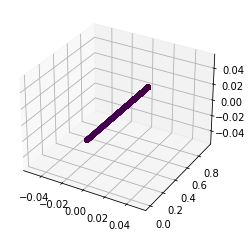

In [0]:
aggregator = FeatureAggregator(model, dataset)
aggregator.run()